In [170]:
import pandas as pd
import numpy as np

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow
from tensorflow import keras
from keras.layers import Dense, BatchNormalization, Dropout
from keras.models import Sequential
from keras.regularizers import L2
from keras.callbacks import EarlyStopping

In [90]:
df=pd.read_csv("/content/Churn_Modelling.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [91]:
df.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [92]:
df=df.iloc[:,3:]
df.head(2)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [94]:
df=pd.get_dummies(df,columns=['Geography','Gender'],dtype=int,drop_first=True)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1,0


In [95]:
x=df.drop('Exited',axis=1)
y=df['Exited']

In [96]:
x.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0


In [97]:
y.value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [98]:
smote=SMOTE()
x,y=smote.fit_resample(x,y)

In [99]:
x.shape

(15926, 11)

In [100]:
y.value_counts()

Exited
1    7963
0    7963
Name: count, dtype: int64

In [117]:
x_train,x_val,y_train,y_val=train_test_split(x,y,test_size=0.2,random_state=1)

In [118]:
x_train.head(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
5375,686,38,7,111484.88,1,1,1,76076.20,0,1,1
9098,473,32,5,146602.25,2,1,1,72946.95,1,0,0


In [119]:
sc=StandardScaler()
x_train=sc.fit_transform(x_train)
x_val=sc.transform(x_val)

In [175]:
model=Sequential()
model.add(Dense(input_dim=11, units=32, activation='relu', kernel_regularizer=L2(0.03), kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(input_dim=11, units=32, activation='relu', kernel_regularizer=L2(0.03), kernel_initializer='he_normal'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_25 (Dense)            (None, 32)                384       
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_8 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 32)                1056      
                                                                 
 dropout_9 (Dropout)         (None, 32)                0         
                                                                 
 batch_normalization_9 (Bat  (None, 32)                128       
 chNormalization)                                    

In [176]:
initial_weights=model.get_weights()

In [177]:
initial_weights[0]

array([[ 3.03379387e-01, -3.80909741e-01,  4.15685058e-01,
         2.18711704e-01,  5.61703295e-02,  6.07606284e-02,
        -3.67014796e-01,  4.91152816e-02, -2.26143315e-01,
         4.42223936e-01,  3.37386318e-02, -4.11260754e-01,
        -4.29150641e-01,  2.07928330e-01, -2.15430200e-01,
         1.94077175e-02,  1.51246861e-01,  5.71003616e-01,
        -2.57363647e-01,  2.44369432e-01,  3.47714037e-01,
        -3.04733157e-01,  2.11587623e-01,  5.36122024e-01,
        -3.99354380e-03, -1.32107228e-01,  4.39615160e-01,
         5.67203403e-01, -7.90100574e-01,  9.78808105e-03,
        -4.44766998e-01,  6.25583529e-01],
       [-2.23398671e-01,  4.89073582e-02,  8.55178237e-02,
        -9.09614980e-01,  3.92029911e-01, -4.25832957e-01,
        -1.68837793e-03, -3.89937371e-01, -2.98136417e-02,
         2.43563741e-03,  3.06471676e-01, -8.10503781e-01,
        -4.18852329e-01, -5.14603376e-01,  2.61684805e-01,
        -4.22776461e-01, -9.90592167e-02, -4.78738993e-01,
         1.88

In [178]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='accuracy')

In [179]:
early_stopping = EarlyStopping(monitor='accuracy',patience=10,min_delta=0.01,restore_best_weights=True)

In [180]:
hist=model.fit(x_train,y_train,validation_data=(x_val,y_val),epochs=30,batch_size=32,callbacks=early_stopping)

Epoch 1/30
399/399 [==============================] - 4s 6ms/step - loss: 2.5105 - accuracy: 0.7066 - val_loss: 1.2694 - val_accuracy: 0.7932
Epoch 2/30
399/399 [==============================] - 1s 3ms/step - loss: 0.9061 - accuracy: 0.7752 - val_loss: 0.6130 - val_accuracy: 0.8267
Epoch 3/30
399/399 [==============================] - 1s 3ms/step - loss: 0.5660 - accuracy: 0.7960 - val_loss: 0.4618 - val_accuracy: 0.8299
Epoch 4/30
399/399 [==============================] - 1s 3ms/step - loss: 0.4828 - accuracy: 0.8050 - val_loss: 0.4244 - val_accuracy: 0.8289
Epoch 5/30
399/399 [==============================] - 1s 3ms/step - loss: 0.4608 - accuracy: 0.8069 - val_loss: 0.4076 - val_accuracy: 0.8315
Epoch 6/30
399/399 [==============================] - 1s 3ms/step - loss: 0.4491 - accuracy: 0.8100 - val_loss: 0.3956 - val_accuracy: 0.8343
Epoch 7/30
399/399 [==============================] - 1s 3ms/step - loss: 0.4399 - accuracy: 0.8137 - val_loss: 0.4043 - val_accuracy: 0.8343
Epoch 

Text(0.5, 1.0, 'Training vs Validation Accuracy')

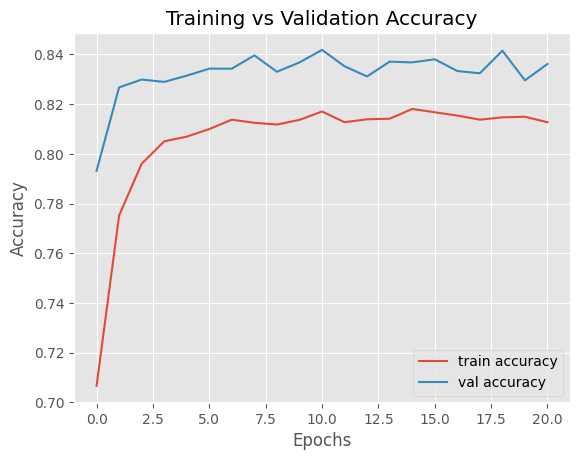

In [181]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(np.arange(0,21),hist.history['accuracy'],label='train accuracy')
plt.plot(np.arange(0,21),hist.history['val_accuracy'],label='val accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")

Text(0.5, 1.0, 'Training vs Validation Loss')

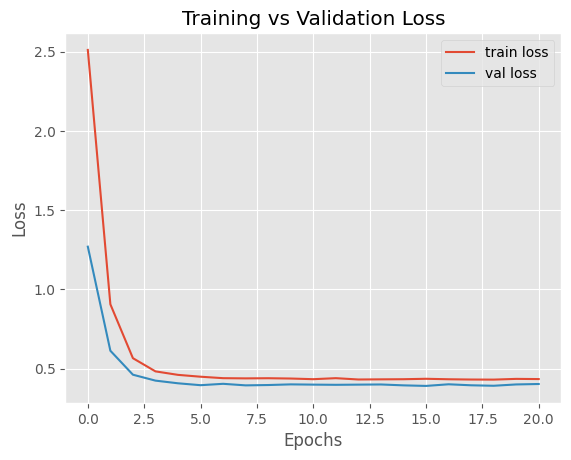

In [182]:
plt.plot(np.arange(0,21),hist.history['loss'],label='train loss')
plt.plot(np.arange(0,21),hist.history['val_loss'],label='val loss')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")